In [7]:
# example of lotka-volterra dynamics

using DifferentialEquations
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, δ, γ = p
  du[1] = dx = α*x - β*x*y
  du[2] = dy = -δ*y + γ*x*y
end
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0,tspan,p)
sol = solve(prob,Tsit5())


┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1192
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswe

ArgumentError: ArgumentError: Package Plots not found in current path:
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell


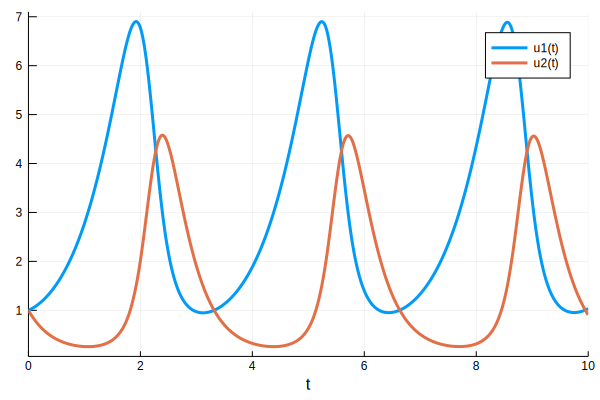

In [11]:
using Plots

plot(sol)

# Bayesian inference via invertible neural networks

In [53]:

ndata = randn(N).*s .+ m

100-element Array{Float64,1}:
  3.3586323330848957  
 12.18314973727219    
 -0.8755457882440743  
 -1.0613388391634713  
 10.927126468762513   
  3.618632837663755   
  2.923034225421901   
  1.0777409723929987  
 -4.150189499898886   
  5.037279849595631   
 -4.145382160430092   
  3.7500370410673605  
 10.477408198741077   
  ⋮                   
  8.324422203590554   
  4.752477531336917   
 -5.620916693924437   
  6.221199205219486   
  0.2565375231407758  
 -1.2246962025562595  
  0.12576227758875524 
  0.022424267080826565
  3.534872182359658   
  7.85082652157041    
  1.2756816854806703  
 -1.060934845955238   

In [38]:
using Flux, DiffEqFlux, DifferentialEquations
using Flux: chunk, leakyrelu

┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1192
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
Core: Haswell
ERROR: LoadError: No deps.jl file could be found. Please try running Pkg.build("Arpack").
Currently, the build command might fail when Julia has been built from source
and the recommendation is to use the official binaries from julialang.org.
For more info see https://github.com/JuliaLinearAlgebra/Arpack.jl/issues/5.

Stacktrace:
 [1] top-level scope at /Users/jmorton/.julia/packages/Arpack/cu5By/src/Arpack.jl:19
 [2] include at ./boot.jl:317 [inlined]
 [3] include_relative(::Module, ::String) at ./loading.jl:1044
 [4] include(::Module, ::String) at ./sysimg.jl:29
 [5] top-level scope at none:2
 [6] eval at ./boot.jl:319 [inlined]
 [7] eval(::Expr) at ./client.jl:393
 [8] top-level scope at ./none:3
in expression

ErrorException: Failed to precompile DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0] to /Users/jmorton/.julia/compiled/v1.0/DiffEqFlux/BdO4p.ji.

In [57]:
datasize = 100
s = 5
m = 2

tspan = (0.0f0,10f0)
x = range(tspan[1],tspan[2],length=datasize)

0.0f0:0.1010101f0:10.0f0

In [43]:
function inv_block(inp, out)
    s1 = Dense(inp//2, out//2, leakyrelu)
    s2 = Dense(inp//2, out//2, leakyrelu)
    t1 = Dense(inp//2, out//2, leakyrelu)
    t2 = Dense(inp//2, out//2, leakyrelu)
    
    function f(x)
        xs = chunk(x, 2) 
        v1 = xs[1] .* exp.(s2(xs[1])) + t2(xs[2])
        v2 = xs[2] .* exp.(s1(v1)) + t1(v1)          
        return vcat(v1, v2)
    end
end

inv_block (generic function with 1 method)

In [55]:
logfx(x) = (x-m)^2 / s^2
dudx(x) = -x^2 / 2

dudx (generic function with 1 method)

In [44]:
dFdt = Chain(inv_block, inv_block, inv_block)
n_ode(x) = neural_ode(dFdt, x, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

n_ode (generic function with 1 method)

In [46]:
ps = Flux.params(dFdt)

Params([])

In [47]:
f0 = [0.0]
function predict_n_ode()
  n_ode(f0)
end

predict_n_ode (generic function with 1 method)

In [48]:
loss_n_ode() = sum(abs2, (logfx(x) / dudx(x)) .-  predict_n_ode())

loss_n_ode (generic function with 2 methods)

In [37]:
opt = ADAM(0.1)
data = Iterators.repeated((), 100)
Flux.train!(loss_n_ode, ps, data, opt)

(0.0f0, 1.5f0)

LoadError: syntax: "\" is not a unary operator